In [1]:
# !pip install ultralytics

In [2]:
# !pip install networkx

In [3]:
import numpy as np
import os
import cv2 as cv
from ultralytics import YOLO
import torch
import pandas as pd
import networkx as nx
from itertools import combinations
import matplotlib.pyplot as plt

## Loading the pretraining model

In [4]:
cwd = os.getcwd()

In [5]:
# model = YOLO("yolov8m.pt")
model = YOLO(cwd + "/best (1).pt")

In [6]:
# model.train(data="/content/drive/MyDrive/pr2/data.yaml", epochs=100)

### Recognition of components and nets from pic

In [7]:
results = model.predict(cwd + '/imgs/4.png')
result = results[0]


image 1/1 d:\Graduation work\project\imgs\4.png: 512x640 2 caps, 2 inds, 12 nets, 13 net_nodes, 4 ress, 4 sources, 529.1ms
Speed: 0.0ms preprocess, 529.1ms inference, 10.0ms postprocess per image at shape (1, 3, 512, 640)


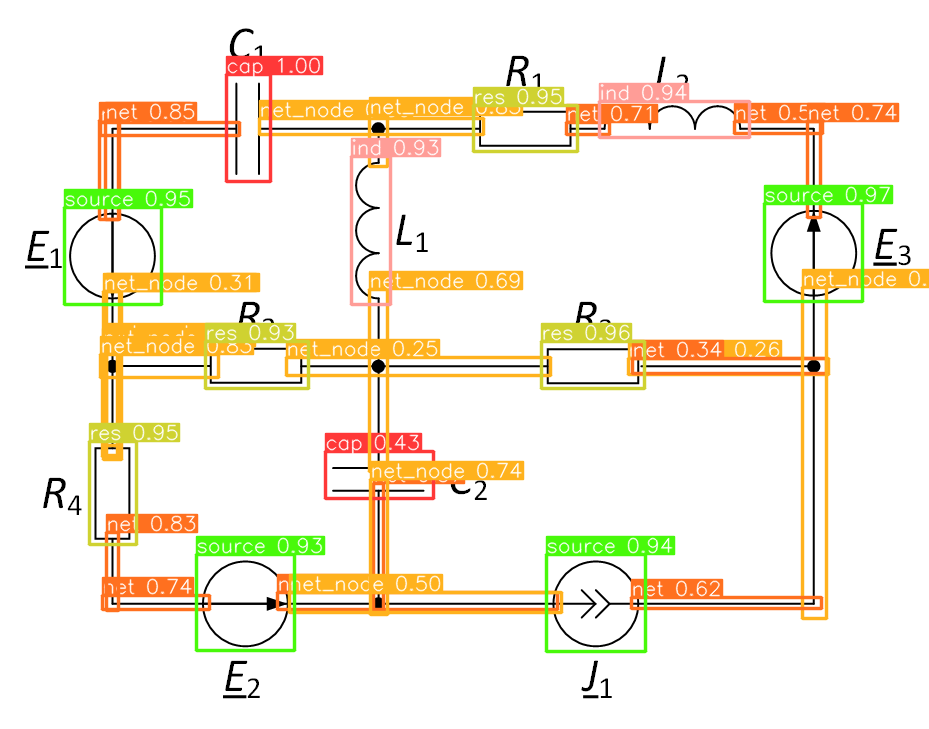

In [8]:
from PIL import Image
Image.fromarray(result.plot()[:,:,::-1])

### Preprocessing obtained results

In [9]:
# Printing names of recognized components

# for r in result:
#   for c in r.boxes.cls:
#     match c:
#       case 0: print('Capacitor')
#       case 1: print('Inductor')
#       case 2: print('Net')
#       case 3: print('Net_node')
#       case 4: print('Resistor')
#       case 5: print('Source')

In [10]:
# Assign values to obtained bounding boxes: name_of_component + index_of_component

components = ['cap', 'ind', 'net', 'net_node', 'res', 'src']
data = []
for i, c in enumerate(result.boxes.cls.cpu().numpy()):
  data.append((components[c.astype(np.int32)], i))
data = np.array(data)


In [11]:
# Names of recognized components
data[:,0]

array(['cap', 'src', 'res', 'res', 'src', 'res', 'src', 'ind', 'src', 'res', 'ind', 'net', 'net_node', 'net_node', 'net', 'net_node', 'net', 'net', 'net', 'net_node', 'net', 'net', 'net', 'net', 'net_node', 'net_node', 'cap', 'net_node', 'net', 'net', 'net', 'net_node', 'net_node', 'net_node', 'net_node', 'net_node',
       'net_node'], dtype='<U11')

In [12]:
# Indices of components
all_indices = data[:,1].astype(np.int32)
print(f'All component indices:\n{all_indices}')

All component indices:
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36]


In [13]:
# Indices of nets
net_indices = data[:,1][np.where(data[:,0] == 'net')].astype(np.int32)
netnode_indices = data[:,1][np.where(data[:,0] == 'net_node')].astype(np.int32)
nets_indices = np.concatenate((net_indices, netnode_indices),axis=0)
componets_indices = np.setdiff1d(all_indices, nets_indices)
print(f'Net indices:\n{net_indices}')
print(f'Net + node indices:\n{netnode_indices}')
print(f'All indices related to nets:\n{nets_indices}')
print(f'All indices related to components:\n{componets_indices}')

Net indices:
[11 14 16 17 18 20 21 22 23 28 29 30]
Net + node indices:
[12 13 15 19 24 25 27 31 32 33 34 35 36]
All indices related to nets:
[11 14 16 17 18 20 21 22 23 28 29 30 12 13 15 19 24 25 27 31 32 33 34 35 36]
All indices related to components:
[ 0  1  2  3  4  5  6  7  8  9 10 26]


In [14]:
def sort_indices(indices):
  '''
  Function for sorting indices

  :param indices: indices to sort
  :return: sorted indices
  '''

  for i in range(len(indices)):
    for j in range(len(indices)):
      if (result.boxes.xyxy[indices[i]].cpu().numpy().astype(np.int32)[0] >= result.boxes.xyxy[indices[j]].cpu().numpy().astype(np.int32)[0]):
        indices[i], indices[j] = indices[j], indices[i]
  return indices[::-1]

### Function for vsualize bounding boxes

In [15]:
def visualize_boxes(path_to_img, indices):
  '''
  Function for visualizing bounding boxes

  :param path_to_img: path to image
  :param indices: indices of boxes to visualize
  '''

  img = cv.imread(path_to_img)
  for ind in indices:
    x1, y1, x2, y2 = result.boxes.xyxy.cpu().numpy().astype(np.int32)[ind]
    top_left = (x1,y1)
    bottom_right = (x2,y2)
    color = (0, 255, 0)
    cv.rectangle(img, pt1=top_left, pt2=bottom_right, color=color)
  plt.imshow(img)
  plt.axis('off')
  plt.show()

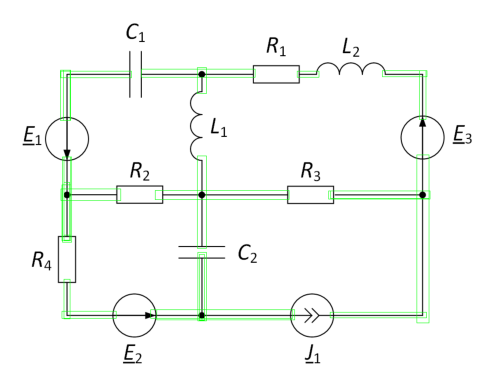

In [16]:
visualize_boxes(cwd + '/imgs/4.png', nets_indices)

## Building graph from obtained bounding boxes

### Functions for building a graph

In [17]:
def rectangles_intersect(rect1_indx, rect2_indx):
  '''
  Function for checking the intersection two bounding boxes

  :param rect1_indx: index of first bounding box
  :param rect2_indx: index of second bounding box
  :return: True if rectangles intersect else False
  '''

  x1_rect1, y1_rect1, x2_rect1, y2_rect1 = result.boxes.xyxy[rect1_indx].cpu().numpy().astype(np.int32)
  x1_rect2, y1_rect2, x2_rect2, y2_rect2 = result.boxes.xyxy[rect2_indx].cpu().numpy().astype(np.int32)

  x_intersect = max(x1_rect1, x1_rect2) <= min(x2_rect1, x2_rect2)
  y_intersect = max(y1_rect1, y1_rect2) <= min(y2_rect1, y2_rect2)

  return x_intersect and y_intersect

In [18]:
def laplacian_matrix(indices):
  '''
  Function for obtainig matrices which describe graph - degree matrix, adjencency matrix, laplacian matrix

  :param indices: all indices required for building a graph
  :return: laplacian_matrix, degree_matrix, adjacency_matrix
  '''
  inds = indices.copy()
  adjacency_matrix = np.zeros((len(inds), len(inds)))
  degree_matrix = np.zeros((len(inds), len(inds)))
  laplacian_matrix = np.zeros((len(inds), len(inds)))
  counter = 0
  for i in inds:
    for j in inds:
      if (rectangles_intersect(i, j)):
        if i != j:
          adjacency_matrix[i][j] = 1
          counter += 1
    degree_matrix[i][i] = counter
    counter = 0
  laplacian_matrix = degree_matrix - adjacency_matrix

  return laplacian_matrix, degree_matrix, adjacency_matrix

In [19]:
lap_mx, dg_mx, adj_mx = laplacian_matrix(all_indices)

### Library [**NetworkX**](https://networkx.org/documentation/stable/index.html) will be used for working with graphs. Obtained above matrices can't be used for analyzing electric circuit - it's needed to transform graph (eliminate or merge in groups bounding boxes related to nets).

In [20]:
# Making graph from Adjacency matrix

g = nx.from_numpy_array(adj_mx)

In [21]:
# Checking has graph got subgraphs inside or not

subgraphs = [g.subgraph(c).copy() for c in nx.connected_components(g)]
number_of_subgraphs = len(subgraphs)
print(f'{number_of_subgraphs} subgraphs in initial graph')
if number_of_subgraphs > 1:
  for i, g in enumerate(subgraphs,start=1):
    print(f"Subgraph {i}: Nodes: {g.nodes()} Edges: {g.edges()}")

1 subgraphs in initial graph


### Removing nodes related to components and defining the subgraphs related to nets

In [22]:
adj_list = {}
edges = []
Graphs = []

for subgraph in subgraphs:
  # removing nodes related to components
  mask = np.in1d(subgraph.nodes(), componets_indices)
  nodes_of_comp = np.array(subgraph.nodes())[mask]
  sub_without_components = subgraph.copy()
  sub_without_components.remove_nodes_from(nodes_of_comp)

  #
  nets = [sub_without_components.subgraph(c).copy() for c in nx.connected_components(sub_without_components)]
  for comp in nodes_of_comp:
    neig = np.array(list(subgraph.neighbors(comp)))
    for i, sub in enumerate(nets):
      if True in np.in1d(neig, sub.nodes()):
        edges.append(i)
    adj_list[comp] = list(edges)
    edges.clear()
  nodes = np.arange(len(nets))

  # building new graphs
  G = nx.MultiGraph()
  G.add_nodes_from(nodes)
  G.add_edges_from(adj_list.values())

  Graphs.append(G)

  # cleaning variables
  adj_list.clear()
  edges.clear()

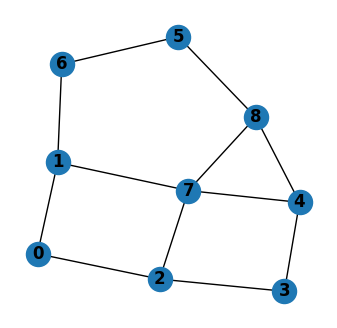

In [23]:
plt.figure(figsize=(9, 4))
for i, g in enumerate(Graphs, start=1):
  plt.subplot(1,2, i)
  nx.draw(g, with_labels=True, font_weight='bold')
plt.show()

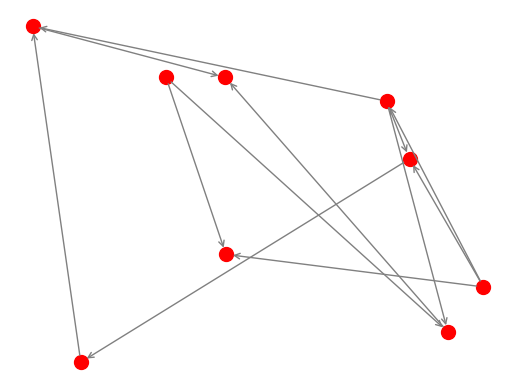

In [ ]:
# pos = nx.random_layout(Graphs[1], seed=0xC0FFEE)
# nx.draw_networkx_nodes(Graphs[1], pos, node_color = 'r', node_size = 100, alpha = 1)
# ax = plt.gca()
# for e in Graphs[1].edges:
#     ax.annotate("",
#                 xy=pos[e[0]], xycoords='data',
#                 xytext=pos[e[1]], textcoords='data',
#                 arrowprops=dict(arrowstyle="->", color="0.5",
#                                 shrinkA=5, shrinkB=5,
#                                 patchA=None, patchB=None,
#                                 connectionstyle="arc3,rad=rrr".replace('rrr',str(0.3*e[2])
#                                 ),
#                                 ),
#                 )
# plt.axis('off')
# plt.show()